## Disclaimer: The content in this notebook is for informational purposes only, you should not construe any such information or other material as legal, tax, investment, financial, or other advice.

The goal of this notebook is to calculate portfolio allocations that will minimize risk (standard deviation) for a desired level of returns. I will look at how portfolio allocations when I am allowed to invest in a "risk free asset" and when I am not allowed to.

I pull data from yahoo finance for 10 different stocks:
* CVX: Chevron
* JPM: JP Morgan
* WMT: Walmart
* F: Ford
* MCK: Mckesson
* T: AT&T
* PPG: PPG Industries
* NKE: Nike
* GE: General Electric
* IBM: International Business Machines

The OptimalPortfolio class works with n number of assets where n >= 2.

In [1]:
## Import necessary packages
import pandas as pd
import numpy as np
import yfinance as yf
import math
import matplotlib.pyplot as plt
import warnings

## Ignore FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
class OptimalPortfolio:
    def __init__(self, start_date = '2000-01-01', end_date = '2021-12-31',
                 returns_frequency = 'Y', names = None,
                 mu = .1, rf_asset_ind = False, verbose_ind = False):
        
        
        self._start_date = start_date
        self._end_date = end_date
        self._returns_frequency = returns_frequency
        
        self._mu = mu
        self._sd = None
        self._sharpe = None
        self._names = names
        self._prices = list()
        self._pricedf = pd.DataFrame({})
        self._num_assets = 0
        self._verbose_ind = verbose_ind
        
        self._rf_asset_ind = rf_asset_ind
        self._rf_asset_name = "^TNX"
        self._rf_data = None
        
        self._returns_df_f = None
        self._returns_array_f = None
        self._cov_matrix = None
        
        self._A = None
        self._b = None
        
        self._multipliers = None
        self._weights = None
        self._weights_dict = None
                 
    def calc_num_assets(self):
        self._num_assets = int(len(self._names))
        
    def check_rf_asset(self):
        if self._rf_asset_ind == True:
            self._num_assets += 1
    
    def can_run(self):
        if self._num_assets < 2:
            raise ValueError(f"At least 2 assets needed, {self._num_assets} assets were provided")            
        else:
            print(f"Optimizing portfolio with {self._num_assets}")    
    def gather_data(self):
        for name in self._names:
            self._prices.append(yf.download(name, start = self._start_date,
                                            end = self._end_date)[['Adj Close']])    
        
        if self._rf_asset_ind == True:
            self._rf_data = yf.download(self._rf_asset_name, start = self._start_date,
                                        end = self._end_date)[['Adj Close']]
        
        for p in range(len(self._prices)):
            self._pricedf[self._names[p]] = self._prices[p]
        
            
    def calc_returns_frequency(self):
        self._returns_df_f = self._pricedf.resample(self._returns_frequency).ffill().pct_change().dropna()
        if self._rf_asset_ind == True:
            yearly_rf = self._rf_data.resample('Y').agg({'Adj Close':'mean'})
            self._returns_df_f['rf_asset'] = yearly_rf/100
            
            if 'rf' not in self._names:
                self._names.append('rf')

        avg_returns = np.mean(self._returns_df_f)
        
        if self._verbose_ind:
            print(f"Mean Returns:\n{avg_returns}")
        self._returns_array_f = avg_returns.to_numpy()
        
    def calc_cov_matrix(self):
        self._cov_matrix = self._returns_df_f.cov().to_numpy()
        
    def create_formula_matrices(self):
        A = np.vstack((self._cov_matrix, self._returns_array_f))
        A = np.concatenate((A, np.append(self._returns_array_f, 0)[:, None]), axis = 1)

        last_row = np.concatenate((np.repeat(1, self._num_assets), np.repeat(0, 1)))
        last_col = np.concatenate((np.repeat(-1, self._num_assets), np.repeat(0, 2)))

        A = np.vstack((A, last_row))
        A = np.concatenate((A, last_col[:, None]), axis = 1)
        
        self._A = A
        self._b = np.concatenate((np.repeat(0, self._num_assets), np.array([self._mu]), np.array([1])), axis = 0)
        
    def calc_optimal_portfolio(self):
        X = np.linalg.inv(self._A).dot(self._b)
        self._weights = X[:self._num_assets]
        self._weights_dict = {self._names[i]: X[i] for i in range(len(self._names))}
        self._multipliers = X[self._num_assets:]
        
    def print_portfolio_allocations(self):
        for i in range(len(self._weights)):
            print(f'The share of wealth allocated to {self._names[i]} is {round(self._weights[i] * 100, 4)}%')

    def get_portfolio_stats(self):
        self._returns_frequency = self._returns_frequency.lower()
        var = 0
        for i in range(self._num_assets):
            for j in range(self._num_assets):
                var = var + self._weights[i] * self._weights[j] * self._cov_matrix[i,j]
        
        ret = 0 
        
        for i in range(len(self._weights)):
            ret += self._weights[i] * self._returns_array_f[i]
        
        self._sd = math.sqrt(var)
        
        print(f"Minimized standard deviation to obtain {round(self._mu*100, 2)}% returns: {round(self._sd*100, 3)}%")
        
        if round(self._mu, 3) == round(ret, 3):
            print(f"mu({round(self._mu, 3)}) = calculated return level({round(ret, 3)})")
        else:
            print(f"mu({round(self._mu, 3)}) != calculated return level({round(ret, 3)})")
        if self._rf_asset_ind:
            self._sharpe = (ret - self._returns_array_f[-1]) / self._sd
        else: 
            self._sharpe = (ret) / self._sd
        print(f"Sharpe Ratio: {round(self._sharpe, 3)}")
    def data_gather_tasks(self):
        self.calc_num_assets()
        self.check_rf_asset()
        self.can_run()
        self.gather_data()

    def analysis_tasks(self):
        self.calc_returns_frequency()
        self.calc_cov_matrix()
        self.create_formula_matrices()
        self.calc_optimal_portfolio()
        if self._verbose_ind:
            self.print_portfolio_allocations()
        self.get_portfolio_stats()

In [3]:
portfolio_optimizer = OptimalPortfolio(rf_asset_ind = False,
                                       names = ['CVX', 'JPM', 'WMT', 'F', 'MCK',
                                                'T', 'PPG', 'NKE', 'GE', 'IBM'],
                                       mu = .2, verbose_ind = False)

portfolio_optimizer.data_gather_tasks()

Optimizing portfolio with 10
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
allocations_wo_rf = {}
risk_level_wo_rf = {}
for i in np.arange(.05, .21, .01):
    portfolio_optimizer._mu = round(i, 3)
    portfolio_optimizer.analysis_tasks()
    allocations_wo_rf[round(i, 3)] = portfolio_optimizer._weights_dict
    risk_level_wo_rf[round(i, 3)] = portfolio_optimizer._sd
    
## Create result DataFrames
allocations_df_wo_rf = pd.DataFrame.from_dict(allocations_wo_rf, orient = 'index')
risk_level_df_wo_rf = pd.DataFrame.from_dict(risk_level_wo_rf, orient = 'index', columns = ['stdev'])

Minimized standard deviation to obtain 5.0% returns: 12.761%
mu(0.05) = calculated return level(0.05)
Sharpe Ratio: 0.392
Minimized standard deviation to obtain 6.0% returns: 12.426%
mu(0.06) = calculated return level(0.06)
Sharpe Ratio: 0.483
Minimized standard deviation to obtain 7.0% returns: 12.148%
mu(0.07) = calculated return level(0.07)
Sharpe Ratio: 0.576
Minimized standard deviation to obtain 8.0% returns: 11.933%
mu(0.08) = calculated return level(0.08)
Sharpe Ratio: 0.67
Minimized standard deviation to obtain 9.0% returns: 11.783%
mu(0.09) = calculated return level(0.09)
Sharpe Ratio: 0.764
Minimized standard deviation to obtain 10.0% returns: 11.7%
mu(0.1) = calculated return level(0.1)
Sharpe Ratio: 0.855
Minimized standard deviation to obtain 11.0% returns: 11.687%
mu(0.11) = calculated return level(0.11)
Sharpe Ratio: 0.941
Minimized standard deviation to obtain 12.0% returns: 11.743%
mu(0.12) = calculated return level(0.12)
Sharpe Ratio: 1.022
Minimized standard deviati

In [5]:
portfolio_optimizer = OptimalPortfolio(rf_asset_ind = True,
                                       names = ['CVX', 'JPM', 'WMT', 'F', 'MCK',
                                                'T', 'PPG', 'NKE', 'GE', 'IBM'],
                                       mu = .2, verbose_ind = False) 
portfolio_optimizer.data_gather_tasks()

Optimizing portfolio with 11
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [6]:
allocations_w_rf = {}
risk_level_w_rf = {}

for i in np.arange(.05, .21, .01):
    portfolio_optimizer._mu = round(i, 3)
    portfolio_optimizer.analysis_tasks()
    allocations_w_rf[round(i, 3)] = portfolio_optimizer._weights_dict
    risk_level_w_rf[round(i, 3)] = portfolio_optimizer._sd

allocations_df_w_rf = pd.DataFrame.from_dict(allocations_w_rf, orient = 'index')
risk_level_df_w_rf = pd.DataFrame.from_dict(risk_level_w_rf, orient = 'index', columns = ['stdev'])

Minimized standard deviation to obtain 5.0% returns: 1.81%
mu(0.05) = calculated return level(0.05)
Sharpe Ratio: 1.06
Minimized standard deviation to obtain 6.0% returns: 2.515%
mu(0.06) = calculated return level(0.06)
Sharpe Ratio: 1.16
Minimized standard deviation to obtain 7.0% returns: 3.252%
mu(0.07) = calculated return level(0.07)
Sharpe Ratio: 1.205
Minimized standard deviation to obtain 8.0% returns: 4.002%
mu(0.08) = calculated return level(0.08)
Sharpe Ratio: 1.229
Minimized standard deviation to obtain 9.0% returns: 4.76%
mu(0.09) = calculated return level(0.09)
Sharpe Ratio: 1.243
Minimized standard deviation to obtain 10.0% returns: 5.522%
mu(0.1) = calculated return level(0.1)
Sharpe Ratio: 1.253
Minimized standard deviation to obtain 11.0% returns: 6.287%
mu(0.11) = calculated return level(0.11)
Sharpe Ratio: 1.26
Minimized standard deviation to obtain 12.0% returns: 7.053%
mu(0.12) = calculated return level(0.12)
Sharpe Ratio: 1.264
Minimized standard deviation to obta

In [7]:
## Check out correlation between assets
portfolio_optimizer._returns_df_f.corr()

,CVX,JPM,WMT,F,MCK,T,PPG,NKE,GE,IBM,rf_asset
CVX,1.000000,0.539766,0.081272,0.279073,0.294050,0.593467,0.347746,0.220701,0.489091,0.587745,0.125407
JPM,0.539766,1.000000,0.239542,0.513889,0.442361,0.585192,0.602770,0.508436,0.625054,0.405678,-0.330428
WMT,0.081272,0.239542,1.000000,-0.090333,0.056164,0.100273,0.287787,0.119844,-0.062964,0.146060,-0.377349
F,0.279073,0.513889,-0.090333,1.000000,0.522839,0.144317,0.562574,0.389674,0.274809,0.611285,-0.170932
MCK,0.294050,0.442361,0.056164,0.522839,1.000000,0.214226,0.569423,0.539469,0.501838,0.340136,-0.173902
T,0.593467,0.585192,0.100273,0.144317,0.214226,1.000000,0.379709,0.242757,0.680757,0.459919,-0.036416
PPG,0.347746,0.602770,0.287787,0.562574,0.569423,0.379709,1.000000,0.526487,0.544799,0.472497,-0.216451
NKE,0.220701,0.508436,0.119844,0.389674,0.539469,0.242757,0.526487,1.000000,0.577685,0.261245,-0.241712
GE,0.489091,0.625054,-0.062964,0.274809,0.501838,0.680757,0.544799,0.577685,1.000000,0.430843,-0.206795
IBM,0.587745,0.405678,0.146060,0.611285,0.340136,0.459919,0.472497,0.261245,0.430843,1.000000,0.035736


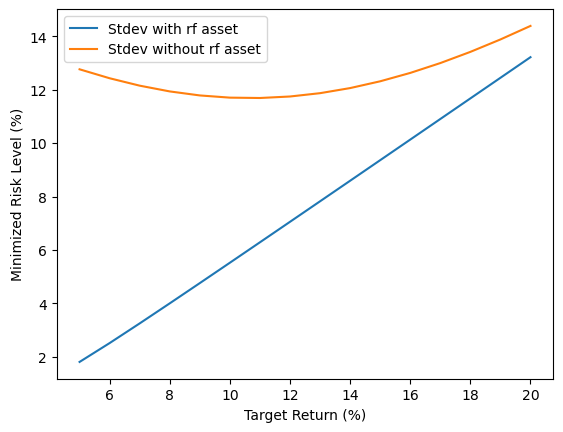

In [8]:
plt.plot(risk_level_df_w_rf.index * 100, risk_level_df_w_rf['stdev'] * 100, label = 'Stdev with rf asset')
plt.plot(risk_level_df_wo_rf.index * 100, risk_level_df_wo_rf['stdev'] * 100, label = 'Stdev without rf asset')
plt.xlabel('Target Return (%)')
plt.ylabel('Minimized Risk Level (%)')
plt.legend()
plt.show()

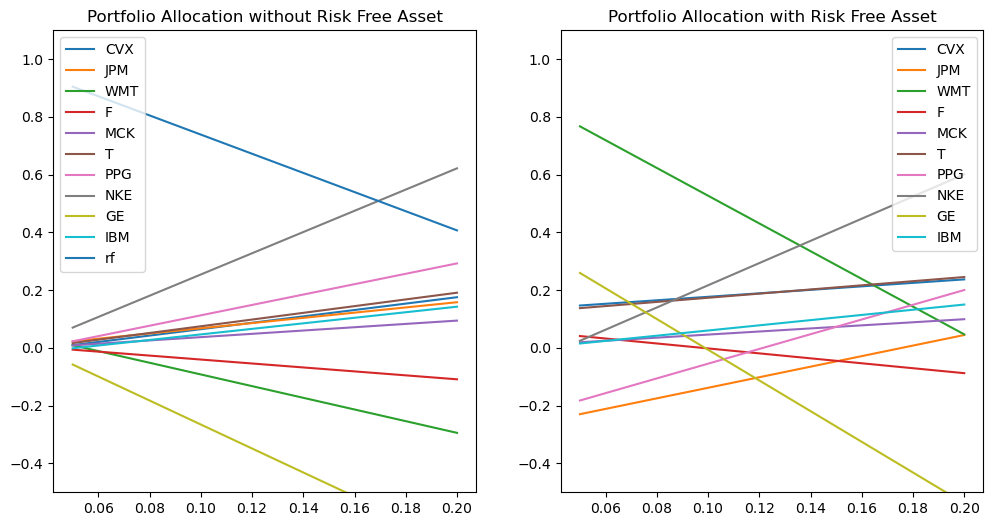

In [9]:
fig, axs = plt.subplots(1, 2, figsize = (12,6))
for name in allocations_df_w_rf.columns:
    axs[0].plot(allocations_df_w_rf.index, allocations_df_w_rf[name], label = name)
    
axs[0].set_title('Portfolio Allocation without Risk Free Asset')
axs[0].legend(loc = 'upper left')
axs[0].set_ylim(bottom = -.5, top = 1.1)

for name in allocations_df_wo_rf.columns:
    axs[1].plot(allocations_df_wo_rf.index, allocations_df_wo_rf[name], label = name)
    
axs[1].set_title('Portfolio Allocation with Risk Free Asset')
axs[1].legend(loc = 'best')
axs[1].set_ylim(bottom = -.5, top = 1.1)

plt.show()